## Use this script to load the Matlab simulated Ronchigram, resize, add noise, then pair with emittance and aberratio coeffs, and combine them into one single file
The 1024 px Ronchigram and aberration functions are too big, reshape the Ronchigrams to 128 px, add noise, then save it together with emittance from aberration function and the aberration coefficients. Both emittance and abr coeff are just numbers, should be very small in size.

In [1]:
%matplotlib nbagg

# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import cv2
import glob
from random import randrange
from mpl_toolkits.axes_grid1 import make_axes_locatable

from PIL import Image, ImageEnhance 

## Process simulated Ronchigram with random cutoff aperture and noise
Cutoff aperture is added here, simulated Ronchigram from Matlab has no cutoff aperture.

In [70]:
# modified version, include different convergence angle and different noise level
# filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/*midAbr*30limit*.mat')
# filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/Gaussian_32px/StandardDefocus/Validation/*35limit_128px*validation.mat')
filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/Nion_2ndOrder_validation/*50limit_15mradShift*.mat')
filelist

['/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/Nion_2ndOrder_validation/FullRandom_2ndOrder_Nion_WhiteNoise_50limit_15mradShift_128px_x1000_1_validation.mat']

In [71]:
# Load 10 simulated data, assign random cutoff aperture and noise level, aperture option is not in use
path = 'ValidationData_CoarseCNN/Nion_50mrad_45mradAperture/'
ronch = []
abr_coeff = []
emit = []
aperture = []
defocus = []

# Acquisition condition for Ronchigrams used when simulating
simdim = 55
numpx = 128
current = 270 # current=30 within 20 mrad, current = 270 for 60 mrad aperture
emit_range = 45

# range in mrad for the cutoff aperture, generate list for aperture size in step size of 1 mrad
# Currently not in use, no limiting aperture in the current simulation
aperture_min = 25
aperture_max = 40
aperture_list = np.arange(aperture_min, aperture_max + 1)
apply_mask = False

dtime_list = [100]
for dtime in dtime_list:
    for filename in filelist:
        temp = sio.loadmat(filename)
        abr_func = temp['chi0_final']
        for j in range(1000):
            # only take 200 frames from each dataset
            # append the aberration coefficient and emittance, the emittance is also calculated with 40 mrad cutoff range.
            abr_coeff.append(temp['aberration_final']['mag'][0][j])
            emit.append(np.sqrt(CalcEmittance_3(abr_func[:,:,j], simdim, emit_range)))  # calculate emittance within emit_range mrad

            # single ronchigram with mask applied, mask is not currently in use
            temp2 = temp['ronch_final'][:,:,j]

            if apply_mask:
                ronch.append(reshape_noise_frame(temp2, numpx, current, dtime) * mask)
            else:
                ronch.append(reshape_noise_frame(temp2, numpx, current, dtime))

            # save the defocus
            defocus.append(abs(temp['aberration_final']['mag'][0][j][0][0]))
        
        print(filename)
        np.save(path + str(simdim) + 'mradLimit_15mradShift_' + str(dtime) + 'ms_128pxRonch.npy', ronch)
    
        # validation data shares the same emittance and defocus regardless of the dwell time
np.save(path + str(simdim) + 'mradLimit_15mradShift_' + str(emit_range) + 'mrademit.npy', emit )
np.save(path + str(simdim) + 'mradLimit_15mradShift_defocus.npy', defocus)
print(len(ronch))
print(len(emit))
print(len(defocus))

/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/Nion_2ndOrder_validation/FullRandom_2ndOrder_Nion_WhiteNoise_50limit_15mradShift_128px_x1000_1_validation.mat
1000
1000
1000


<IPython.core.display.Javascript object>


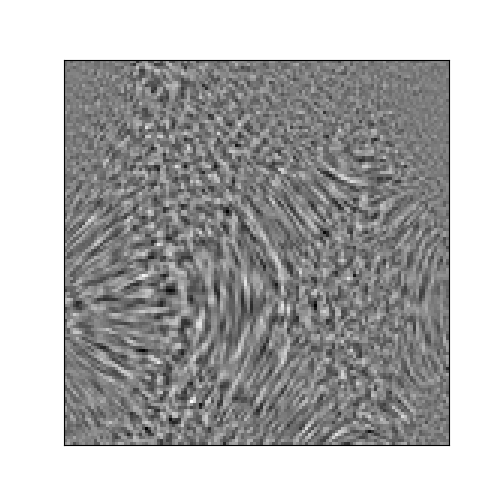

[]

In [42]:
fig, ax = plt.subplots(1,1, figsize = [5,5])
img = ax.imshow(ronch[120], 
                cmap = 'gray')
ax.set_xticks([])
ax.set_yticks([])

## Data Check
1. Visulize the whole index list, see if that is random
2. Visulize the ronchigram correspond to the smallest and largest emittance, check the match between Ronchigram and emit
3. Visulize the realtionship between emittance and single aberration coeff, check the match between emit and abr coeff

In [2]:
emit = np.load('TrainingData_CoarseCNN/FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_25mrademit_x25000.npy')
ronch = np.load('TrainingData_CoarseCNN/FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy')
defocus = np.load('TrainingData_CoarseCNN/FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy')

In [36]:
sort_idx = np.argsort(emit)
print(np.amin(emit))
print(np.amax(emit))

0.027011885696504635
25586.25921303857


In [19]:
sort_idx = np.argsort(defocus)
print(np.amin(defocus))
print(np.amax(defocus))

0.07599346409196528
199.6535617886321


In [20]:
label1 = emit / np.amax(emit)
label2 = defocus / np.amax(defocus)
label = (label1 + label2)/2
sort_idx = np.argsort(label1)

<IPython.core.display.Javascript object>


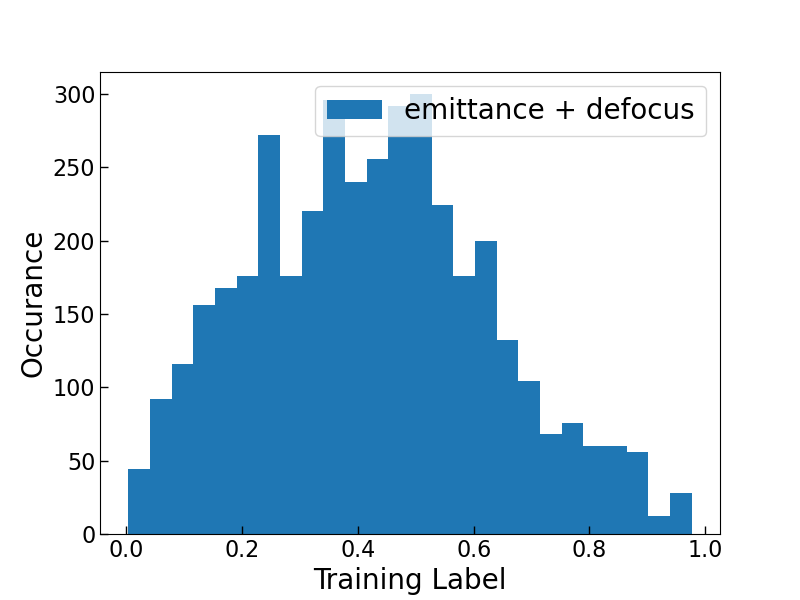

In [21]:
fig = plt.figure(figsize = [8,6])
ax = fig.add_subplot()
# ax.hist(label1, bins='auto', label = 'emittance')  # arguments are passed to np.histogram
# plt.title("Emittance Histogram")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Training Label', fontsize = 20)
# plt.xlabel('Normalzied $\epsilon$(pm\u2022rad)',fontsize=20)
plt.ylabel('Occurance',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

ax.hist(label, bins='auto', label = 'emittance + defocus')  # arguments are passed to np.histogram
plt.legend(fontsize = 20)

<IPython.core.display.Javascript object>


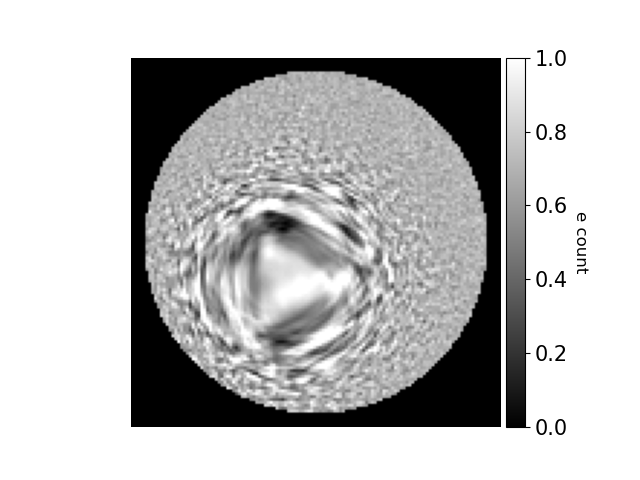

In [23]:
mask = aperture_generator(128, 30, 28)
plt.imshow(mask)

<IPython.core.display.Javascript object>


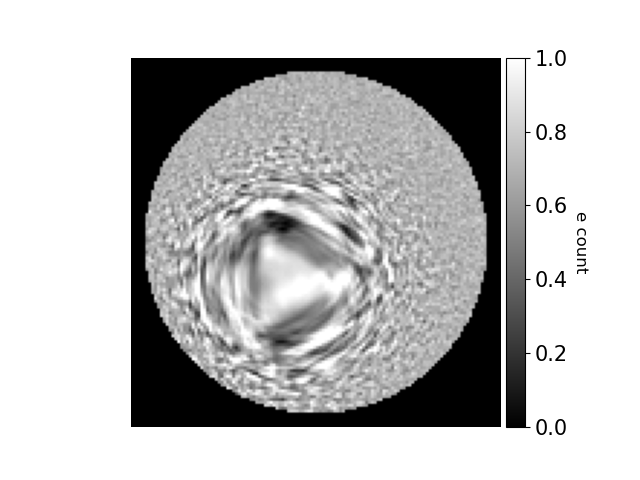

0.8119814171659171


In [26]:
ax = plt.subplot(111)
idx = -10

frame = ronch[sort_idx[idx]].astype('float')
frame = scale_range(frame, 0, 1)
frame = frame * 1.5
frame[frame > 1] = 1
im = plt.imshow(frame * mask, cmap='gray')

plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('e count',fontsize = 12, rotation=270)
print(label[sort_idx[idx]])

<IPython.core.display.Javascript object>


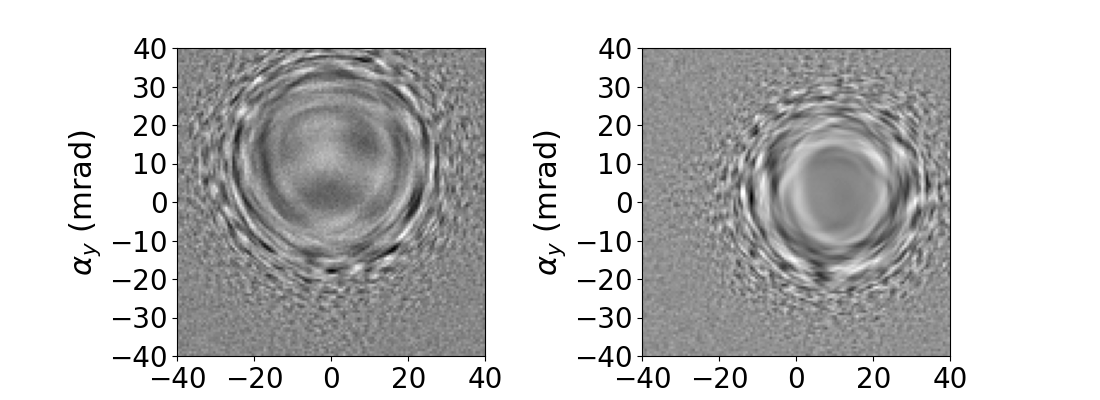

941.131091823763
154.10720751237275
0.42204449251496245
State 2:
3465.319586773201
61.67440539443021
0.2874059315291705


In [27]:
# show examples of Ronchigrams with minimum and maximum emittance
low_idx = 1000
plt.figure(figsize=[11,4])
plt.subplot(121)
plt.imshow(ronch[sort_idx[low_idx]], extent = [-simdim, simdim, -simdim, simdim], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=22)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.colorbar()
print(emit[sort_idx[low_idx]])
print(defocus[sort_idx[low_idx]])
print(label[sort_idx[low_idx]])

plt.subplot(122)    
high_idx = -2000
plt.imshow(ronch[sort_idx[high_idx]], extent = [-simdim, simdim, -simdim, simdim], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=22)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
print('State 2:')
print(emit[sort_idx[high_idx]])
print(defocus[sort_idx[high_idx]])
print(label[sort_idx[high_idx]])

## Aux functions

In [6]:
# Latest function that calculate emittance from determinant of covariance matrix
def CalcEmittance_3(abr, simdim, ap_size):

    imdim = abr.shape[0]
    px_size = simdim / (imdim/2) # pixel size in mrad
    px_size = px_size / 1000 # pixel size in rad

    abr_gradient = np.gradient(abr)
    # Divide by pixel size
    abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size
    abr_gradient[0] = abr_gradient[0] * 1.97 / 2 / 3.14  # multiply by lambda/2pi to get real space coordinate in pm
    abr_gradient[1] = abr_gradient[1] * 1.97 / 2 / 3.14

    x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    ax, ay = np.meshgrid(x, y)

    apt_mask = np.sqrt(ax*ax + ay*ay) < (ap_size / 1000) # aperture mask
    idx = (apt_mask != 0)
    
    # flatten x, y, ax, ay matrix and build covariance matrix
    idx = idx.flatten()
    ax = ax.flatten()[idx]
    ay = ay.flatten()[idx]
    x = abr_gradient[0].flatten()[idx]
    y = abr_gradient[1].flatten()[idx]

    cov_mat = np.cov([x,ax,y,ay])
    # return square root of determinant, which is the emittance in the 4D phase space
    return np.sqrt(np.linalg.det(cov_mat))

In [7]:
# Function to resample input array (arr) to new_shape, only work when the new shape is integer times smaller than original 
# array.
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [8]:
def reshape_noise(arr, side_length, current, dtime):
    # optional: normalize the rochigrams, resample to 128x128 px, then add noise
    arr_reshape = np.zeros((side_length,side_length,arr.shape[2]))
    for i in range(arr.shape[2]):
        temp = arr[:,:,i]
        temp = rebin(temp,[side_length, side_length])
        temp = temp / np.sum(temp)
        temp = temp * current * dtime / 1.6 * 10000   # convert to number of electrons
        temp = np.random.poisson(temp)
        arr_reshape[:,:,i] = temp
    return arr_reshape

In [9]:
def reshape_noise_frame(frame, side_length, current, dtime):
# reshape and add noise for a single frame
    temp = rebin(frame,[side_length, side_length])
    # for new simulation with antialiasing, need to subtract background, contrast very small
    temp_sum = np.sum(temp)
    temp = temp - np.amin(temp) # get minimum intensity to zero
    temp = temp / np.sum(temp) * temp_sum # rescale to get same sum as before
    # No need to normalize if the input data is already normalized
#     temp = temp / np.sum(temp)
    temp[temp<0] = 0
    temp = temp * current * dtime / 1.6 * 10000   # convert to number of electrons
    temp = np.random.poisson(temp)
    return temp

In [10]:
def mask_generator(stack, simdim, ap_size):
    imdim = stack.shape[0]
    x = np.linspace(-simdim/1000, simdim/1000, imdim)
    y = np.linspace(-simdim/1000, simdim/1000, imdim)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
    return apt_mask

In [11]:
def pi_4_radius(probe, simdim):
    probe_binary = np.abs(probe) > math.pi/4
    radius = simdim # start with the maximum radius
    mask = mask_generator(probe, simdim, radius)
    overlap = np.sum(probe_binary * mask)
    while overlap > 0:
        radius = radius - 1
        mask = mask_generator(probe, simdim, radius)
        overlap = np.sum(probe_binary * mask)
    return radius

In [12]:
def PhaseDiff(probe, simdim, ap_size):
    mask = mask_generator(probe, simdim, ap_size)
    probe_mask = probe * mask
    return np.amax(np.abs(probe_mask)), np.sum(np.abs(probe_mask)) / np.sum(mask)

In [13]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [14]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input 

## Functions not in use

In [15]:
# Earliest emittance calculation without normalizing, cannot get emittance in meaningful physical units
def CalcEmittance(abr, simdim, ap_size):
    imdim = abr.shape[0]
    abr_gradient = np.gradient(abr)
    x = np.linspace(-simdim/1000, simdim/1000, imdim)
    y = np.linspace(-simdim/1000, simdim/1000, imdim)
    xv, yv = np.meshgrid(x, y)
    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture
    apt_mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask
    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1]))
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv))
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv))
    emit = emit_1 * emit_2 - emit_3**2
    return emit

In [16]:
def CalcEmittance_new(abr, simdim, ap_size):

    imdim = abr.shape[0]
    px_size = simdim / (imdim/2) # pixel size in mrad
    px_size = px_size / 1000 # pixel size in rad

    abr_gradient = np.gradient(abr)
    abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size

    x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    xv, yv = np.meshgrid(x, y)

    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture, correspond to A^2
    apt_mask = np.sqrt(xv*xv + yv*yv) < (ap_size / 1000) # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1])) * px_size**2
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv)) * px_size**2
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv)) * px_size**2
    emit = np.sqrt(emit_1 * emit_2 - emit_3 * emit_3)

    return emit